In [8]:
import os
import json
import torch
import torch.nn as nn
import random
import copy
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPModel, CLIPProcessor

random.seed(100)

# load CLIP
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# freeze!
for param in clip_model.parameters():
    param.requires_grad = False

# unfreeze attention pooling layer
for param in clip_model.vision_model.encoder.layers[-1].parameters():
    param.requires_grad = True

# print trainable parameters
for name, param in clip_model.named_parameters():
    if param.requires_grad:
        print("Will train:", name)

Will train: vision_model.encoder.layers.11.self_attn.k_proj.weight
Will train: vision_model.encoder.layers.11.self_attn.k_proj.bias
Will train: vision_model.encoder.layers.11.self_attn.v_proj.weight
Will train: vision_model.encoder.layers.11.self_attn.v_proj.bias
Will train: vision_model.encoder.layers.11.self_attn.q_proj.weight
Will train: vision_model.encoder.layers.11.self_attn.q_proj.bias
Will train: vision_model.encoder.layers.11.self_attn.out_proj.weight
Will train: vision_model.encoder.layers.11.self_attn.out_proj.bias
Will train: vision_model.encoder.layers.11.layer_norm1.weight
Will train: vision_model.encoder.layers.11.layer_norm1.bias
Will train: vision_model.encoder.layers.11.mlp.fc1.weight
Will train: vision_model.encoder.layers.11.mlp.fc1.bias
Will train: vision_model.encoder.layers.11.mlp.fc2.weight
Will train: vision_model.encoder.layers.11.mlp.fc2.bias
Will train: vision_model.encoder.layers.11.layer_norm2.weight
Will train: vision_model.encoder.layers.11.layer_norm2.b

In [9]:
import os
import json
from collections import defaultdict

# 国家及路径
json_paths = {
    'cn': 'ground_truth_cn.json',
    'de': 'ground_truth_de.json',
    'in': 'ground_truth_in.json',
}

image_dirs = {
    'cn': 'cn',
    'de': 'de',
    'in': 'in',
}

# 合并 ground truth（加国家前缀，避免重复文件名）
combined_ground_truth = {}
for country, json_path in json_paths.items():
    with open(json_path, 'r') as f:
        gt = json.load(f)
    for fname, label in gt.items():
        new_fname = f"{country}_{fname}"
        combined_ground_truth[new_fname] = {
            "label": label,
            "path": os.path.join(image_dirs[country], fname)
        }

# 生成 label 映射
all_labels = sorted(set(item["label"] for item in combined_ground_truth.values()))
label2id = {label: idx for idx, label in enumerate(all_labels)}
id2label = {idx: label for label, idx in label2id.items()}
NUM_CLASSES = len(label2id)

# 聚合同一类图片
per_class_files = defaultdict(list)
for fname, meta in combined_ground_truth.items():
    per_class_files[meta["label"]].append((fname, meta["path"]))

# 每类分配
train_samples, val_samples, test_samples = [], [], []
for label, items in per_class_files.items():
    random.shuffle(items)
    n = len(items)
    n_train = int(0.3 * n)
    n_val = int(0.3 * n)
    n_test = n - n_train - n_val
    val_samples += [(f, p, label2id[label]) for f, p in items[:n_val]]
    test_samples += [(f, p, label2id[label]) for f, p in items[n_val:n_val+n_test]]
    train_samples += [(f, p, label2id[label]) for f, p in items[n_val+n_test:]]


In [10]:
class MultiCountryTrafficDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples  # list of (filename, path, label_id)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        _, img_path, label_id = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        return image, label_id

def collate_fn(batch):
    images, labels = zip(*batch)
    return list(images), torch.tensor(labels)

train_dataset = MultiCountryTrafficDataset(train_samples)
val_dataset   = MultiCountryTrafficDataset(val_samples)
test_dataset  = MultiCountryTrafficDataset(test_samples)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False, collate_fn=collate_fn)

In [11]:
class CLIPFineTuner(nn.Module):
    def __init__(self, clip_model, num_classes):
        super().__init__()
        self.clip = clip_model
        self.classifier = nn.Linear(clip_model.config.projection_dim, num_classes)

    def forward(self, pixel_values):
        features = self.clip.get_image_features(pixel_values=pixel_values)
        return self.classifier(features)

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CLIPFineTuner(clip_model, num_classes=NUM_CLASSES).to(device)

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

In [12]:
num_epochs = 8
train_loss_hist, val_loss_hist, test_loss_hist = [], [], []
train_acc_hist, val_acc_hist, test_acc_hist = [], [], []

best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    # ---- train ----
    model.train()
    total_loss, total, correct = 0, 0, 0
    for images, labels in train_loader:
        inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
        logits = model(inputs["pixel_values"])
        loss = loss_fn(logits, labels.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1).cpu()
        correct += (preds == labels.cpu()).sum().item()
        total += labels.size(0)
    train_loss = total_loss / total
    train_acc = correct / total
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    # ---- validation ----
    model.eval()
    val_loss, val_total, val_correct = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
            logits = model(inputs["pixel_values"])
            loss = loss_fn(logits, labels.to(device))
            val_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1).cpu()
            val_correct += (preds == labels.cpu()).sum().item()
            val_total += labels.size(0)
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    # ---- test ----
    # test_loss, test_total, test_correct = 0, 0, 0
    # with torch.no_grad():
    #     for images, labels in test_loader:
    #         inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
    #         logits = model(inputs["pixel_values"])
    #         loss = loss_fn(logits, labels.to(device))
    #         test_loss += loss.item() * labels.size(0)
    #         preds = logits.argmax(dim=1).cpu()
    #         test_correct += (preds == labels.cpu()).sum().item()
    #         test_total += labels.size(0)
    # test_loss = test_loss / test_total
    # test_acc = test_correct / test_total
    # test_loss_hist.append(test_loss)
    # test_acc_hist.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss/Acc={train_loss:.4f}/{train_acc:.4f} | "
          f"Val Loss/Acc={val_loss:.4f}/{val_acc:.4f} | "
        #   f"Test Loss/Acc={test_loss:.4f}/{test_acc:.4f}"
          )

    # save best weights
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

# restore best model weights
model.load_state_dict(best_model_wts)

Epoch 1/8: Train Loss/Acc=3.1267/0.2957 | Val Loss/Acc=2.6685/0.7500 | 
Epoch 2/8: Train Loss/Acc=2.2043/0.9207 | Val Loss/Acc=1.9038/0.8994 | 
Epoch 3/8: Train Loss/Acc=1.3895/0.9909 | Val Loss/Acc=1.2751/0.9268 | 
Epoch 4/8: Train Loss/Acc=0.8232/0.9939 | Val Loss/Acc=0.8652/0.9482 | 
Epoch 5/8: Train Loss/Acc=0.4953/1.0000 | Val Loss/Acc=0.6434/0.9482 | 
Epoch 6/8: Train Loss/Acc=0.3268/1.0000 | Val Loss/Acc=0.5140/0.9543 | 
Epoch 7/8: Train Loss/Acc=0.2386/1.0000 | Val Loss/Acc=0.4317/0.9634 | 
Epoch 8/8: Train Loss/Acc=0.1842/1.0000 | Val Loss/Acc=0.3837/0.9665 | 


<All keys matched successfully>

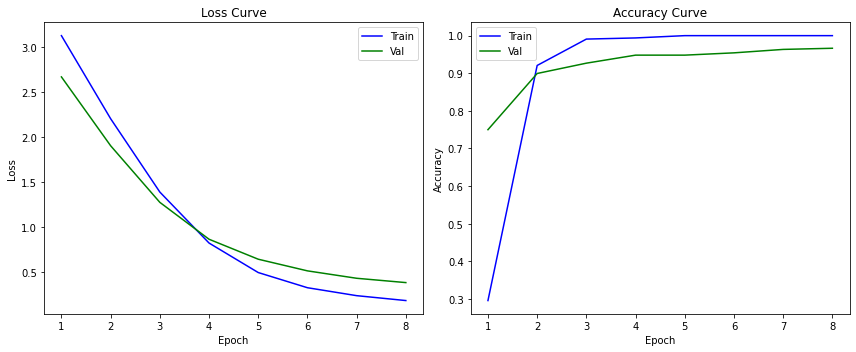

In [13]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_loss_hist, label="Train", color='b')
plt.plot(epochs, val_loss_hist, label="Val", color='g')
# plt.plot(epochs, test_loss_hist, label="Test", color='r')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_acc_hist, label="Train", color='b')
plt.plot(epochs, val_acc_hist, label="Val", color='g')
# plt.plot(epochs, test_acc_hist, label="Test", color='r')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
torch.save(model.state_dict(), "clip_finetuned.pth")